In [1]:
from PIL import Image
import numpy as np
import pandas as pd
import os
print(os.listdir(".\input"))

['usps.h5']


In [2]:
import h5py 
from functools import reduce

def getUspDataSet(path):
    with h5py.File(path, 'r') as hf:
        train = hf.get('train')
        x_Train = train.get("data")[:]
        y_Train = train.get("target")[:]
        test = hf.get('test')
        x_Test = test.get("data")[:]
        y_Test = test.get("target")[:]
    return x_Train, y_Train, x_Test, y_Test

In [3]:
import matplotlib.pyplot as plt

def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image, cmap='binary')
    plt.show()

In [4]:
import matplotlib.pyplot as plt

def plot_images_labels_prediction(images,labels,
                                  prediction,idx,num=10):
    fig = plt.gcf()
    fig.set_size_inches(12, 14)
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images.iloc[idx, np.arange(0, 256)].as_matrix().reshape([16, 16]), cmap='binary')
        title= "label=" +str(labels.iloc[idx,0])
        if len(prediction)>0:
            title+=",predict="+str(prediction.iloc[idx,0]) 
            
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

In [5]:
# 2-norm

def norm2 (a, ak):
    return np.linalg.norm(a-ak, 2)

In [6]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [7]:
x_Train_data = pd.concat([pd.DataFrame(x_Train),pd.DataFrame(y_Train, columns=['digital'])], axis=1)
x_Test_data = pd.concat([pd.DataFrame(x_Test),pd.DataFrame(y_Test, columns=['digital'])], axis=1)

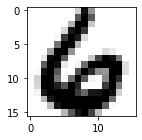

In [8]:
plot_image(x_Train_data.iloc[0, np.arange(0, 256)].as_matrix().reshape([16, 16]))

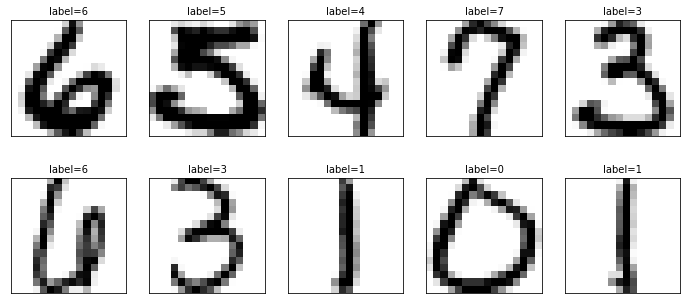

In [9]:
plot_images_labels_prediction(x_Train_data.loc[:,np.arange(0, 256)], x_Train_data.loc[:,['digital']],[],0,)

In [10]:
feature_names = np.array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'Total'])

table = np.zeros((2, 11))

for i in range(11):
    table[0][i] = x_Train_data[x_Train_data['digital'] == i].shape[0]
    table[1][i] = x_Test_data[x_Test_data['digital'] == i].shape[0]
    if i == 10:
        table[0][i] = x_Train_data.shape[0]
        table[1][i] = x_Test_data.shape[0]

pd.DataFrame(table, columns=feature_names)

0       1      2      3      4      5      6      7      8      9  \
0  1194.0  1005.0  731.0  658.0  652.0  556.0  664.0  645.0  542.0  644.0   
1   359.0   264.0  198.0  166.0  200.0  160.0  170.0  147.0  166.0  177.0   

    Total  
0  7291.0  
1  2007.0

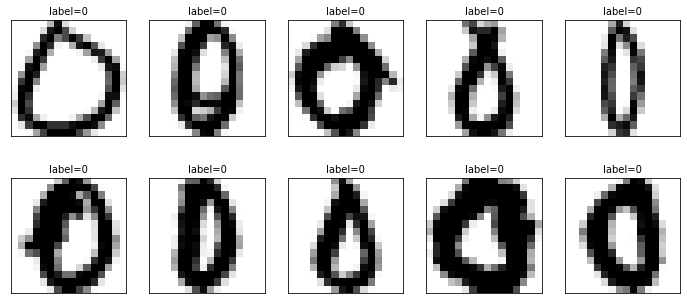

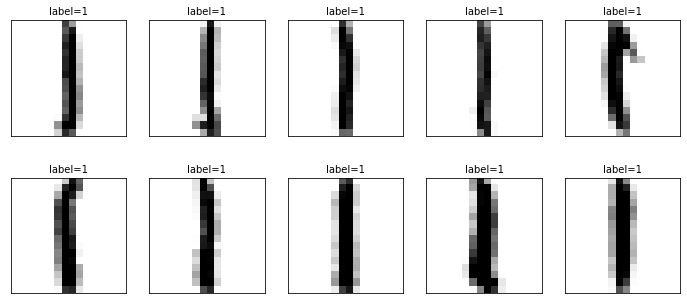

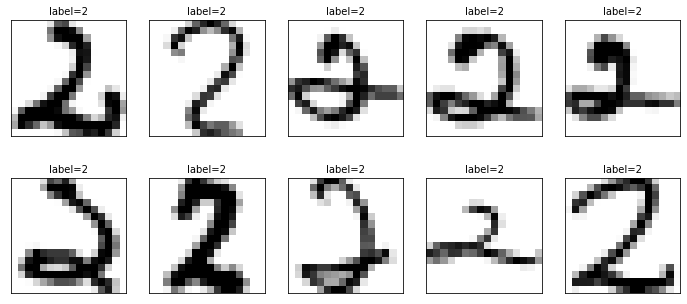

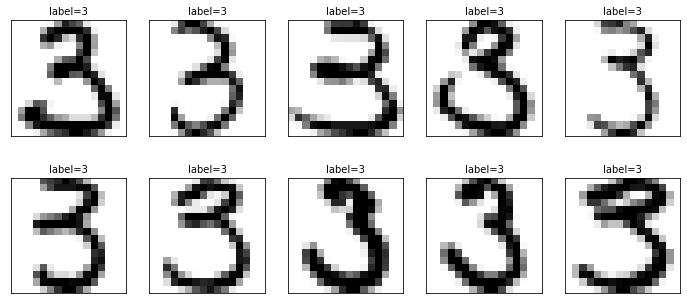

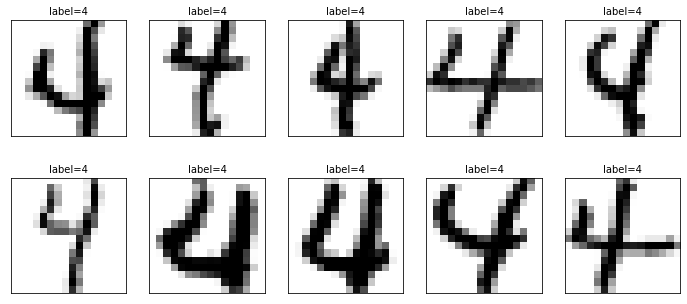

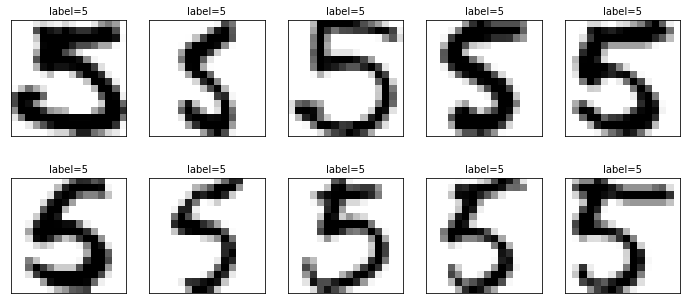

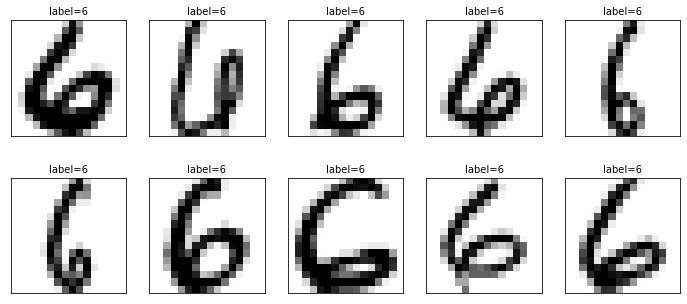

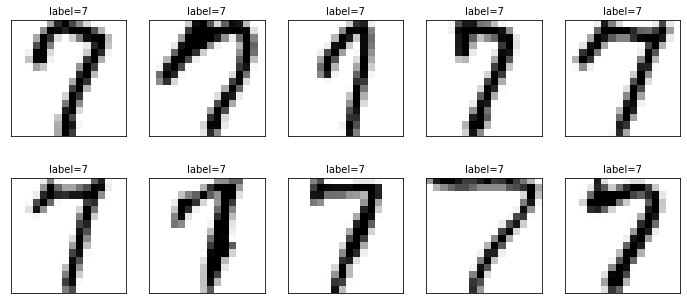

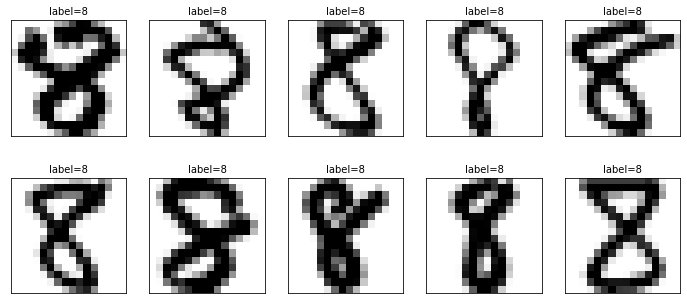

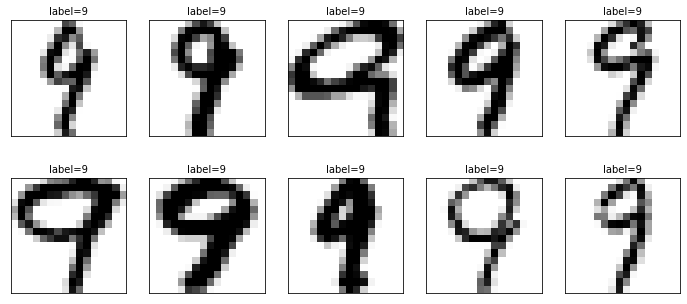

In [11]:
for i in range(0,10):
    plot_images_labels_prediction(x_Train_data[x_Train_data['digital'] == i].loc[:,np.arange(0, 256)], x_Train_data[x_Train_data['digital'] == i].loc[:,['digital']],[],0,)

# Handwritten Digits and a Simple Algorithm

### 透過 training set 取得手寫數字0~9的平均值陣列
### 將 testing set 每一張手寫數字與0~9平均值陣列比對，取最小的2norm，預測該張手寫數字代表的數字

In [12]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [13]:
x_Train_data = pd.concat([pd.DataFrame(x_Train),pd.DataFrame(y_Train, columns=['digital'])], axis=1)
x_Test_data = pd.concat([pd.DataFrame(x_Test),pd.DataFrame(y_Test, columns=['digital'])], axis=1)

In [14]:
def getMeanDigitalTable(x_Data, y_Data):

    x_Date_list = pd.concat([pd.DataFrame(x_Data),pd.DataFrame(y_Data, columns=['digital'])], axis=1)
    meanDigitalTable = np.zeros((10, 257))

    for i in range(10):
        for j in range(257):       
            if j == 256:
                meanDigitalTable[i][j] = int(i)
            else:
                meanDigitalTable[i][j] = x_Date_list[x_Date_list['digital'] == i].loc[:,np.arange(0, 256)].mean(axis = 0)[j]

    x_Train_mean = pd.DataFrame(meanDigitalTable, columns=np.arange(0, 257))

    return x_Train_mean

In [15]:
x_Train_mean = getMeanDigitalTable(x_Train, y_Train)

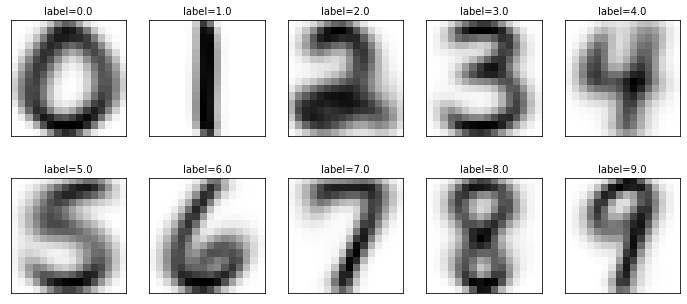

In [16]:
plot_images_labels_prediction(x_Train_mean.loc[:,np.arange(0, 256)], x_Train_mean.loc[:,[256]],[],0,10)

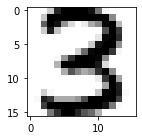

In [17]:
plot_image(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

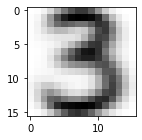

In [18]:
plot_image(x_Train_mean.iloc[3, np.arange(0, 256)].as_matrix().reshape([16, 16]))

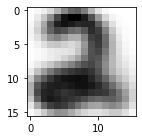

In [19]:
plot_image(x_Train_mean.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

In [20]:
norm2(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]), x_Train_mean.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))

5.097931406215535

In [21]:
def simpleAlgorithm(x_Test_data, x_Train_mean):

    total = x_Test_data.shape[0]
    isSuccess = 0
    isError = 0
    result = np.zeros((total, 1))
    result_residual = np.zeros(total)
    result_residual_list = []

    for i in range(0, total):

        normList = np.zeros((1, 10))

        for j in range(0,10):
            residual_list = np.ones((10))

            normValue = norm2(x_Test_data.iloc[i, np.arange(0, 256)].as_matrix().reshape([16, 16]), x_Train_mean.iloc[j, np.arange(0, 256)].as_matrix().reshape([16, 16]))
            normList[0][j] = normValue

        prediction = np.where(normList == np.amin(normList))

        result[i][0] = int(prediction[1])
        
        result_residual[i] = np.amin(normList)

        result_residual_list.append(normList[0])

    tempPd = pd.concat([x_Test_data, pd.DataFrame(result, columns=['prediction'])], axis=1)
    x_Test_Prediction = pd.concat([tempPd, pd.DataFrame(result_residual, columns=['residual'])], axis=1)
    
    x_Test_result = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].shape[0]/x_Test_Prediction.shape[0]

    return x_Test_Prediction, x_Test_result, result_residual_list

In [22]:
x_Test_Prediction, x_Test_result, result_Test_residual = simpleAlgorithm(x_Test_data, x_Train_mean)

In [23]:
x_Test_Prediction[x_Test_Prediction['prediction'] != x_Test_Prediction['digital']].shape

(448, 259)

In [24]:
print("準確率為 :", x_Test_result)

準確率為 : 0.7767812655705032


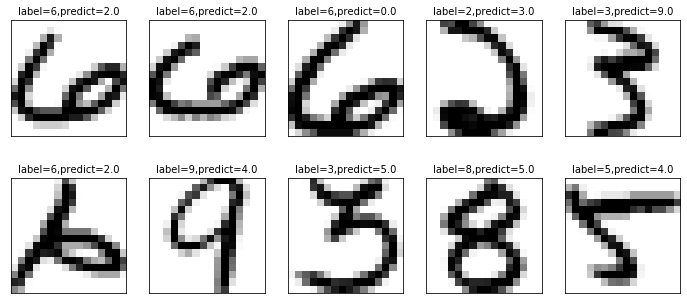

In [25]:
errorList = x_Test_Prediction[x_Test_Prediction['digital'] != x_Test_Prediction['prediction']]

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [26]:
totalCounts = x_Test_Prediction[['digital']].groupby(['digital']).size().reset_index(name='totalCounts')
totalCounts = totalCounts.sort_values('digital', ascending=[True])
errorCounts = errorList[['digital']].groupby(['digital']).size().reset_index(name='errorCounts')
errorCounts = errorCounts.sort_values('digital', ascending=[True])
resultdf = pd.concat([totalCounts,pd.DataFrame(errorCounts, columns=['errorCounts'])], axis=1)
resultdf["successCounts"] = resultdf["totalCounts"]-resultdf["errorCounts"]
resultdf["probability"] = (resultdf["totalCounts"]-resultdf["errorCounts"])/resultdf["totalCounts"]
resultdf.sort_values('probability', ascending=[True])

digital  totalCounts  errorCounts  successCounts  probability
5        5          160           53            107     0.668750
2        2          198           63            135     0.681818
8        8          166           52            114     0.686747
3        3          166           50            116     0.698795
4        4          200           58            142     0.710000
9        9          177           35            142     0.802260
7        7          147           29            118     0.802721
6        6          170           33            137     0.805882
0        0          359           63            296     0.824513
1        1          264           12            252     0.954545

In [27]:
temp = errorList[['digital', 'prediction']].groupby(['digital', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['digital'] == i].sort_values(['digital', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

0    1     2     3     4     5     6     7     8     9
0   6.0  6.0   4.0   5.0   9.0   3.0   0.0   9.0   5.0   4.0
1  35.0  3.0  16.0  21.0  31.0  17.0  10.0  13.0  15.0  15.0
2   5.0  9.0   3.0   0.0   2.0   0.0   5.0   4.0   2.0   8.0
3   8.0  3.0  13.0   9.0   9.0  12.0   9.0   6.0   9.0   8.0

In [28]:
components = np.where(y_Test == 0)[0]
components
x_Test_0 = x_Test[components, :]
y_Test_0 = np.full(x_Test_0.shape[0],0)

x_Test_0_data = pd.concat([pd.DataFrame(x_Test_0),pd.DataFrame(y_Test_0, columns=['digital'])], axis=1)
result_Test_0_list, y_Test_0_predict, result_Test_0_residual = simpleAlgorithm(x_Test_0_data, x_Train_mean)

In [29]:
y_Test_0_predict

0.8245125348189415

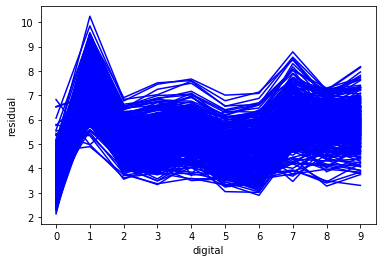

In [30]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_0.shape[0]):
    plt.plot(result_Test_0_residual[i],color = 'blue')

In [31]:
components = np.where(y_Test == 1)[0]
components
x_Test_1 = x_Test[components, :]
y_Test_1 = np.full(x_Test_1.shape[0],1)

x_Test_1_data = pd.concat([pd.DataFrame(x_Test_1),pd.DataFrame(y_Test_1, columns=['digital'])], axis=1)
result_Test_1_list, y_Test_1_predict, result_Test_1_residual = simpleAlgorithm(x_Test_1_data, x_Train_mean)

In [32]:
y_Test_1_predict

0.9545454545454546

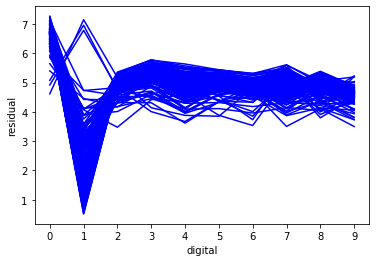

In [33]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_1.shape[0]):
    plt.plot(result_Test_1_residual[i],color = 'blue')

In [34]:
components = np.where(y_Test == 2)[0]
components
x_Test_2 = x_Test[components, :]
y_Test_2 = np.full(x_Test_2.shape[0],2)

x_Test_2_data = pd.concat([pd.DataFrame(x_Test_2),pd.DataFrame(y_Test_2, columns=['digital'])], axis=1)
result_Test_2_list, y_Test_2_predict, result_Test_2_residual = simpleAlgorithm(x_Test_2_data, x_Train_mean)

In [35]:
y_Test_2_predict

0.6818181818181818

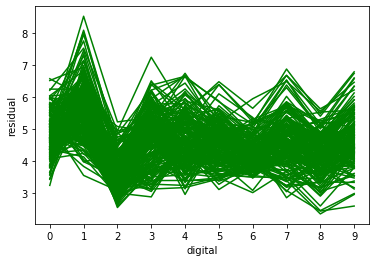

In [36]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_2.shape[0]):
    plt.plot(result_Test_2_residual[i],color = 'green')

In [37]:
components = np.where(y_Test == 5)[0]
components
x_Test_5 = x_Test[components, :]
y_Test_5 = np.full(x_Test_5.shape[0],5)

x_Test_5_data = pd.concat([pd.DataFrame(x_Test_5),pd.DataFrame(y_Test_5, columns=['digital'])], axis=1)
result_Test_5_list, y_Test_5_predict, result_Test_5_residual = simpleAlgorithm(x_Test_5_data, x_Train_mean)

In [38]:
y_Test_5_predict

0.66875

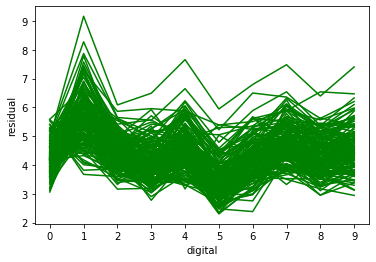

In [39]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_5.shape[0]):
    plt.plot(result_Test_5_residual[i],color = 'green')

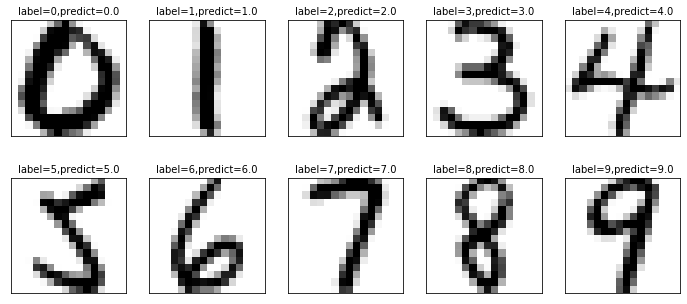

In [40]:
minList = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].groupby('digital').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = x_Test_Prediction[x_Test_Prediction['digital'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = x_Test_Prediction.iloc[x_Test_Prediction.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

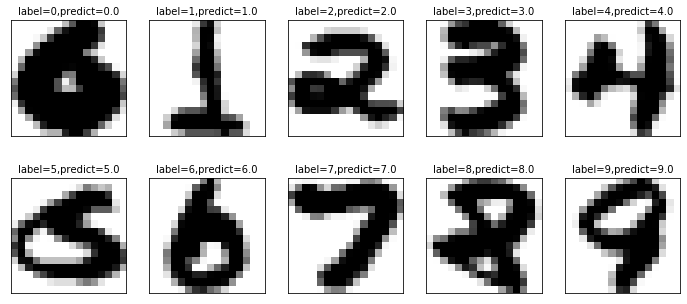

In [41]:
maxList = x_Test_Prediction[x_Test_Prediction['digital'] == x_Test_Prediction['prediction']].groupby('digital').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = x_Test_Prediction[x_Test_Prediction['digital'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = x_Test_Prediction.iloc[x_Test_Prediction.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [42]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [43]:
x_Teacher_data = pd.concat([pd.DataFrame(x_Teacher),pd.DataFrame(y_Teacher, columns=['digital'])], axis=1)

In [44]:
x_Teacher_Prediction, x_Teacher_result, result_Teacher_residual = simpleAlgorithm(x_Teacher_data, x_Train_mean)
x_Teacher_result

0.5

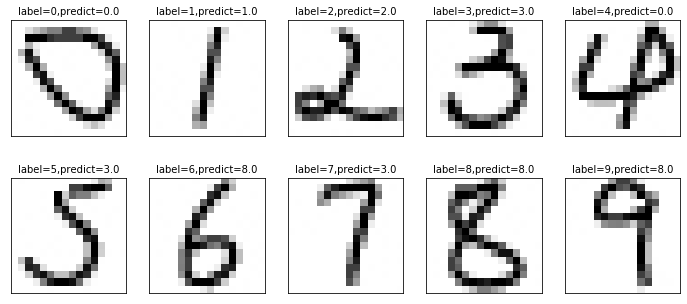

In [45]:
plot_images_labels_prediction(x_Teacher_Prediction.iloc[:,np.arange(0, 256)], x_Teacher_Prediction.iloc[:,[256]], x_Teacher_Prediction.iloc[:,[257]],0,10)

In [46]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [47]:
x_Student_data = pd.concat([pd.DataFrame(x_Student),pd.DataFrame(y_Student, columns=['digital'])], axis=1)

In [48]:
x_Student_Prediction, x_Student_result, result_Student_residual = simpleAlgorithm(x_Student_data, x_Train_mean)
x_Student_result

0.4

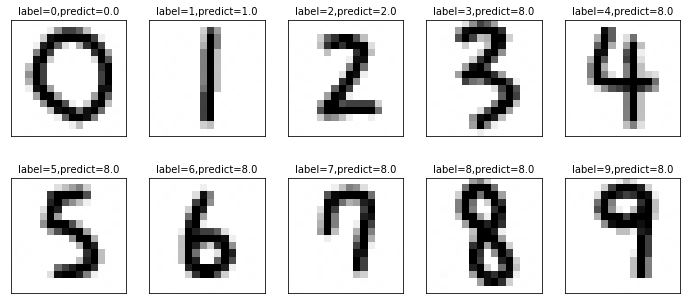

In [49]:
plot_images_labels_prediction(x_Student_Prediction.iloc[:,np.arange(0, 256)], x_Student_Prediction.iloc[:,[256]], x_Student_Prediction.iloc[:,[257]],0,10)

# Classification Using SVD Bases

In [50]:
def getUList(x_Data, y_Data):
    # We now normalize all values between 0 and 1 and we now flatten the 16 × 16 images into vectors of size 256.

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))
    x_Data = x_Data.T
    
    #  we now partition the x_train based on the ten classes and store in a list.

    x_list = []

    for k in range(10):
        components = np.where(y_Data == k)[0]
        x_list.append(x_Data[:, components])

    # we now create a svd basis for each digit data samples.

    U_list = []

    for k in range(10):
        U, S, V = np.linalg.svd(x_list[k])
        U_list.append(U)
    
    return U_list


def svdAlgorithm (x_Data, y_Data, U_list,basis):
    # We now normalize all values between 0 and 1 and we now flatten the 16 × 16 images into vectors of size 256.

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))
    x_Data = x_Data.T

    # we now select the dominant orthogonal basis and project the digits on the reduced basis to compute the least square projection error.

    result_mse = []
    result_residual = []

    for r in range(basis):
        n_Data = x_Data.shape[1]
        y_predict = np.ones(n_Data)
        result_single = np.ones(n_Data)

        for i in range(0, n_Data):
            z = x_Data[:, i]
            residual_list = np.ones(10)
            
            for j in range(10):
                U_k = U_list[j][:, :r+1]
                residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
                residual_list[j] = residual

            y_predict[i] = np.argmin(residual_list)
            
            if r == basis-1:
                result_residual.append(residual_list)
                result_single[i] = np.amin(residual_list)

        result_mse.append(np.mean((y_Data/1.0 - y_predict/1.0) ** 2))
    
    x_Data_list = pd.concat([pd.DataFrame(x_Data.T),pd.DataFrame(y_Data, columns=['actual'])], axis=1)
    result_List = pd.concat([x_Data_list, pd.DataFrame(y_predict, columns=['prediction'])], axis=1)
    result_List = pd.concat([result_List, pd.DataFrame(result_single, columns=['residual'])], axis=1)

    result_predict = result_List[result_List['actual'] == result_List['prediction']].shape[0]/result_List.shape[0]

    return result_List, y_predict, result_predict, result_residual, result_mse

In [51]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [52]:
U_list = getUList(x_Train, y_Train)

In [53]:
result_Train_list, y_Train_predict, result_Train_predict, result_Train_residual, result_Train_mse = svdAlgorithm(x_Train, y_Train, U_list, 12)

In [54]:
result_Train_predict

0.9728432313811548

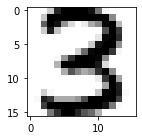

In [55]:
plot_image(x_Test_data.iloc[2, np.arange(0, 256)].as_matrix().reshape([16, 16]))
z = x_Test_data.iloc[2, np.arange(0, 256)]

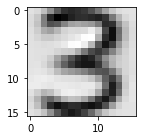

0.2509679228624524

In [56]:
U_k = U_list[3][:, :10+1]
plot_image(np.dot(U_k, np.dot(U_k.T, z)).reshape([16, 16]))
residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
residual

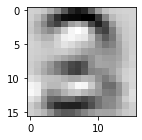

0.49734799699082527

In [57]:
U_k = U_list[2][:, :10+1]
plot_image(np.dot(U_k, np.dot(U_k.T, z)).reshape([16, 16]))
residual = np.linalg.norm(z - np.dot(U_k, np.dot(U_k.T, z)),2)/np.linalg.norm(z,2)
residual

In [58]:
result_Train_list[result_Train_list['prediction'] != result_Train_list['actual']].shape

(198, 259)

In [59]:
result_Train_residual[7290]

array([0.60740066, 0.17074069, 0.54435462, 0.60268408, 0.37695995,
       0.60854   , 0.500844  , 0.52753562, 0.34468952, 0.47261578])

In [60]:
result_Train_mse

[3.198052393361679,
 1.4978740913454944,
 1.2891235770127554,
 0.9462350843505692,
 0.7939925936085585,
 0.7944040597997531,
 0.7104649567960499,
 0.5841448360993005,
 0.5739953367164998,
 0.5336716499794267,
 0.5542449595391579,
 0.5044575504046084]

Text(0.5, 0, 'number of basis')

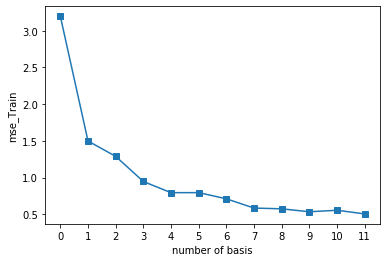

In [61]:
plt.plot(result_Train_mse,'s-')
plt.xticks(range(0,12))
plt.ylabel('mse_Train')
plt.xlabel('number of basis')

In [62]:
result_Test_list, y_Test_predict, result_Test_predict, result_Test_residual, result_Test_mse = svdAlgorithm(x_Test, y_Test, U_list, 12)

In [63]:
result_Test_predict

0.9451918285999004

In [64]:
result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']].shape

(110, 259)

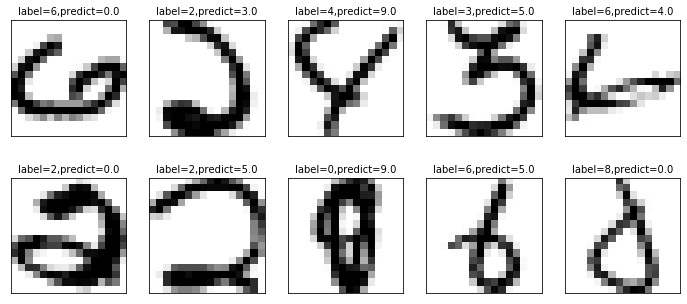

In [65]:
errorList = result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']]

errorList.shape

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [66]:
temp = errorList[['actual', 'prediction']].groupby(['actual', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

0    1    2     3    4    5    6    7    8    9
0  2.0  4.0  0.0   5.0  9.0  3.0  0.0  4.0  0.0  1.0
1  2.0  3.0  8.0  13.0  5.0  4.0  2.0  3.0  3.0  4.0
2  4.0  6.0  4.0   8.0  1.0  9.0  4.0  1.0  3.0  4.0
3  2.0  3.0  3.0   4.0  3.0  3.0  2.0  1.0  3.0  3.0

In [67]:
totalCounts = result_Test_list[['actual']].groupby(['actual']).size().reset_index(name='totalCounts')
totalCounts = totalCounts.sort_values('actual', ascending=[True])
errorCounts = errorList[['actual']].groupby(['actual']).size().reset_index(name='errorCounts')
errorCounts = errorCounts.sort_values('actual', ascending=[True])
resultdf = pd.concat([totalCounts,pd.DataFrame(errorCounts, columns=['errorCounts'])], axis=1)
resultdf["successCounts"] = resultdf["totalCounts"]-resultdf["errorCounts"]
resultdf["probability"] = (resultdf["totalCounts"]-resultdf["errorCounts"])/resultdf["totalCounts"]
resultdf.sort_values('probability', ascending=[True])

actual  totalCounts  errorCounts  successCounts  probability
3       3          166           22            144     0.867470
2       2          198           18            180     0.909091
5       5          160           13            147     0.918750
4       4          200           14            186     0.930000
8       8          166           11            155     0.933735
7       7          147            7            140     0.952381
9       9          177            8            169     0.954802
6       6          170            6            164     0.964706
1       1          264            6            258     0.977273
0       0          359            5            354     0.986072

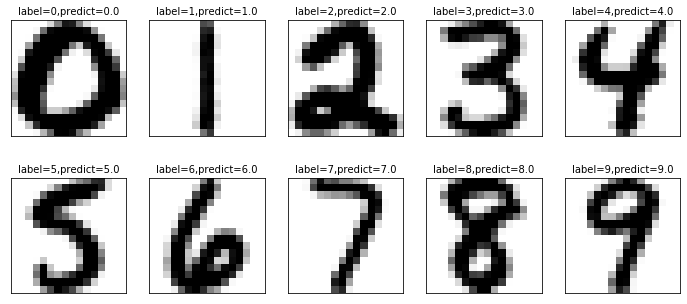

In [68]:
minList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = result_Test_list.iloc[result_Test_list.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

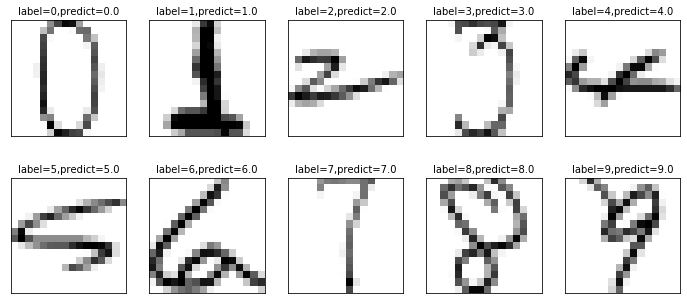

In [69]:
maxList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = result_Test_list.iloc[result_Test_list.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [70]:
result_Test_residual[2006]

array([0.77448362, 0.07644362, 0.66776407, 0.72399628, 0.45119849,
       0.6740846 , 0.59376222, 0.64258456, 0.56563818, 0.55411267])

In [71]:
result_Test_mse

[4.022421524663677,
 2.0269058295964126,
 1.8256103637269556,
 1.4867962132536123,
 1.2227204783258594,
 1.2825112107623318,
 1.1629297458893872,
 1.1031390134529149,
 1.0488290981564523,
 0.9725959142999502,
 0.9785749875435974,
 0.9237668161434978]

Text(0.5, 0, 'number of basis')

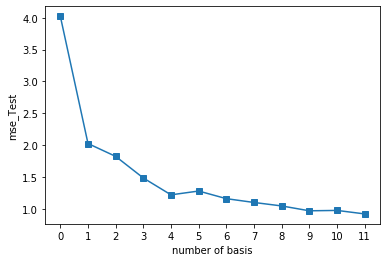

In [72]:
plt.plot(result_Test_mse,'s-')
plt.xticks(range(0,12))
plt.ylabel('mse_Test')
plt.xlabel('number of basis')

In [73]:
components = np.where(y_Test == 0)[0]
components
x_Test_0 = x_Test[components, :]
y_Test_0 = np.full(x_Test_0.shape[0],0)

In [74]:
result_Test_0_list, y_Test_0_predict, result_Test_0_predict, result_Test_0_residual, result_Test_0_mse = svdAlgorithm(x_Test_0, y_Test_0, U_list, 12)

In [75]:
result_Test_0_predict

0.9860724233983287

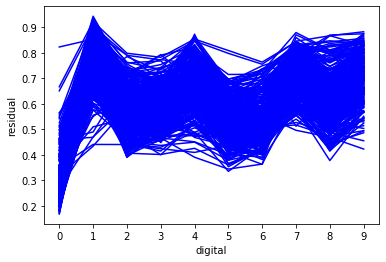

In [76]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_0.shape[0]):
    plt.plot(result_Test_0_residual[i],color = 'blue')

In [77]:
components = np.where(y_Test == 1)[0]
components
x_Test_1 = x_Test[components, :]
y_Test_1 = np.full(x_Test_1.shape[0],1)

In [78]:
result_Test_1_list, y_Test_1_predict, result_Test_1_predict, result_Test_1_residual, result_Test_1_mse = svdAlgorithm(x_Test_1, y_Test_1, U_list, 12)

In [79]:
result_Test_1_predict

0.9772727272727273

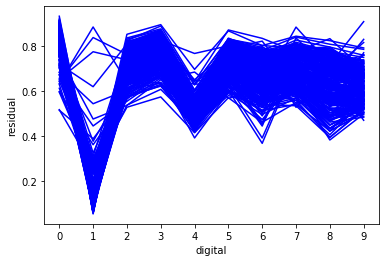

In [80]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_1.shape[0]):
    plt.plot(result_Test_1_residual[i],color = 'blue')

In [81]:
components = np.where(y_Test == 2)[0]
components
x_Test_2 = x_Test[components, :]
y_Test_2 = np.full(x_Test_2.shape[0],2)

In [82]:
result_Test_2_list, y_Test_2_predict, result_Test_2_predict, result_Test_2_residual, result_Test_2_mse = svdAlgorithm(x_Test_2, y_Test_2, U_list, 12)

In [83]:
result_Test_2_predict

0.9090909090909091

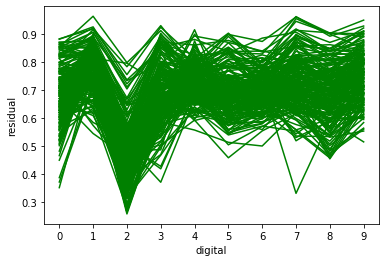

In [84]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_2.shape[0]):
    plt.plot(result_Test_2_residual[i],color = 'green')

In [85]:
components = np.where(y_Test == 3)[0]
components
x_Test_3 = x_Test[components, :]
y_Test_3 = np.full(x_Test_3.shape[0],3)

In [86]:
result_Test_3_list, y_Test_3_predict, result_Test_3_predict, result_Test_3_residual, result_Test_3_mse = svdAlgorithm(x_Test_3, y_Test_3, U_list, 12)

In [87]:
result_Test_3_predict

0.8674698795180723

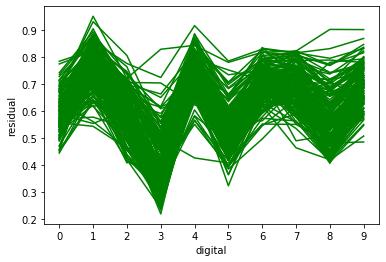

In [88]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_3.shape[0]):
    plt.plot(result_Test_3_residual[i], color = 'green')

In [89]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [90]:
result_Teacher_list, y_Teacher_predict, result_Teacher_predict, result_Teacher_residual, result_Teacher_mse = svdAlgorithm(x_Teacher, y_Teacher, U_list, 12)
result_Teacher_predict

0.9

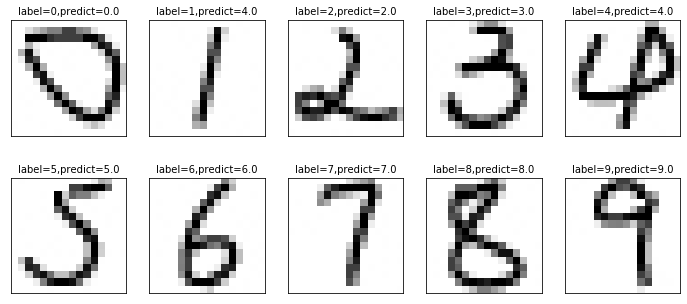

In [91]:
plot_images_labels_prediction(result_Teacher_list.iloc[:,np.arange(0, 256)], result_Teacher_list.iloc[:,[256]], result_Teacher_list.iloc[:,[257]],0,10)

In [92]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [93]:
result_Student_list, y_Student_predict, result_Student_predict, result_Student_residual, result_Student_mse = svdAlgorithm(x_Student, y_Student, U_list, 12)
result_Student_predict

0.9

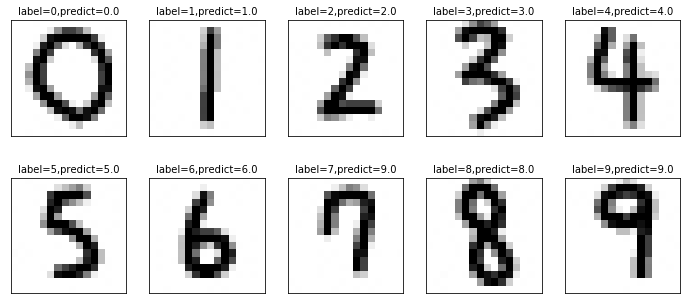

In [94]:
plot_images_labels_prediction(result_Student_list.iloc[:,np.arange(0, 256)], result_Student_list.iloc[:,[256]], result_Student_list.iloc[:,[257]],0,10)

# Classification Using higher order SVD (HOSVD)

In [95]:
import numpy as np
import torch as tc
import tensorly as tl
from tensorly.decomposition import tucker 

from sktensor import dtensor
from sktensor.tucker import hooi

def getSandUList(X_Date):
    X_Date = X_Date.astype('float32') / 255.
    X_Date = X_Date.reshape((len(X_Date), np.prod(X_Date.shape[1:])))

    x_list = []

    for k in range(10):
        components = np.where(y_Train == k)[0]
        x_list.append(x_Train[components, :])

    S_list = []
    U_list = []

    for k in range(10):

        tensor = np.zeros((16, 16, x_list[k].shape[0]))

        for i in range(x_list[k].shape[0]):
            tensor[:,:,i] = x_list[k][i][:].reshape([16, 16])

        A = dtensor(tensor)
        S, U = hooi(A, A.shape, init='nvecs')

        S_list.append(S)
        U_list.append(U)
    
    return S_list, U_list

def hosvdAlgorithm (x_Data, y_Data, S_list, U_list, basis):

    x_Data = x_Data.astype('float32') / 255.
    x_Data = x_Data.reshape((len(x_Data), np.prod(x_Data.shape[1:])))

    result_mse = []
    result_residual = []

    for r in range(basis):
        n_Data = x_Data.shape[0]
        y_predict = np.ones((n_Data))
        result_single = np.ones(n_Data)

        for i in range(0, n_Data):
            Z = x_Data[i][:].reshape([16, 16])
            residual_list = np.ones((10))

            for d in range(10):
                U1, U2, U3 = U_list[d]
                S = S_list[d]
                
                Sigma = np.zeros((16, 16))

                for j in range(r+1):
                    Aj = U1.dot(S[:,:,j]).dot(U2.T)
                    Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
                    Sigma = Sigma + (Cj*Aj)

                G = np.linalg.norm(Z-Sigma, "fro")

                residual_list[d] = G

            y_predict[i] = np.argmin(residual_list)

            if r == basis-1:
                result_residual.append(residual_list)
                result_single[i] = np.amin(residual_list)

        result_mse.append(np.mean((y_Data/1.0 - y_predict/1.0) ** 2))

    x_Data_list = pd.concat([pd.DataFrame(x_Data),pd.DataFrame(y_Data, columns=['actual'])], axis=1)
    result_list = pd.concat([x_Data_list, pd.DataFrame(y_predict, columns=['prediction'])], axis=1)
    result_list = pd.concat([result_list, pd.DataFrame(result_single, columns=['residual'])], axis=1)
    result_prediction = result_list[result_list['prediction'] == result_list['actual']].shape[0]/result_list.shape[0]

    return result_list, y_predict, result_prediction, result_residual, result_mse

In [96]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


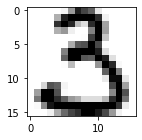

In [97]:
x_Train.shape
plot_image(x_Train[4][:].reshape([16, 16]))

In [98]:
components = np.where(y_Train == 3)[0]
components
x_Train_3 = x_Train[components, :]
y_Train_3 = np.full(x_Train_3.shape[0],3)

x_Train_3.shape

(658, 256)

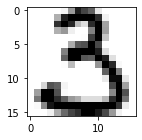

In [99]:
tensor = np.zeros((16, 16, x_Train_3.shape[0]))

for i in range(x_Train_3.shape[0]):
    tensor[:,:,i] = x_Train_3[i][:].reshape([16, 16])

plot_image(tensor[:,:,0])

In [100]:
A = dtensor(tensor)
S, U = hooi(A, A.shape, init='nvecs')

In [101]:
S.shape, U[0].shape, U[1].shape, U[2].shape

((16, 16, 658), (16, 16), (16, 16), (658, 658))

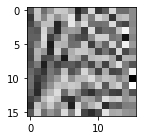

In [102]:
plot_image(U[0])

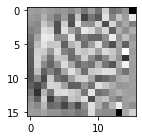

In [103]:
plot_image(U[1])

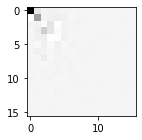

In [104]:
plot_image(S[:,:,0])

In [105]:
A_hosvd = tc.einsum("abc,da,eb,fc->def", tc.as_tensor(S), tc.as_tensor(U[0]), tc.as_tensor(U[1]), tc.as_tensor(U[2]))

In [106]:
hosvd_tensor = tc.Tensor.cpu(A_hosvd).detach().numpy()[:,:,:]

In [107]:
tensor.shape, hosvd_tensor.shape

((16, 16, 658), (16, 16, 658))

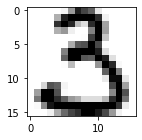

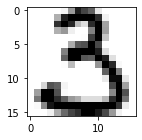

In [108]:
plot_image(tensor[:,:,0])
plot_image(hosvd_tensor[:,:,0])

In [109]:
error = np.linalg.norm(tensor - hosvd_tensor)
error

7.951257058125007e-13

In [110]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [111]:
S_list, U_list = getSandUList(x_Train)

In [112]:
U1, U2, U3 = U_list[3]
S = S_list[3]
S.shape, U1.shape, U2.shape, U3.shape

((16, 16, 658), (16, 16), (16, 16), (658, 658))

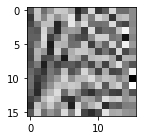

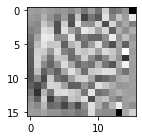

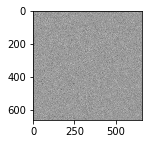

In [113]:
plot_image(U1)
plot_image(U2)
plot_image(U3)

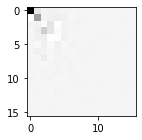

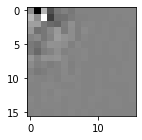

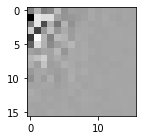

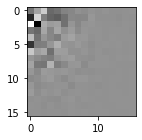

In [114]:
plot_image(S[:,:,0])
plot_image(S[:,:,1])
plot_image(S[:,:,2])
plot_image(S[:,:,3])

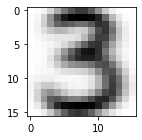

In [115]:
Aj = U1.dot(S[:,:,0]).dot(U2.T)
plot_image(Aj)

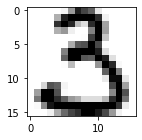

In [116]:
Z = x_Train[4][:].reshape([16, 16])
plot_image(Z)

In [117]:
 Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
 Cj

0.04179627116659144

In [118]:
G = np.linalg.norm(Z-Cj*Aj,"fro")
G

3.984306785591351

In [119]:
U1, U2, U3 = U_list[2]
S = S_list[2]
S.shape, U1.shape, U2.shape, U3.shape

((16, 16, 731), (16, 16), (16, 16), (731, 731))

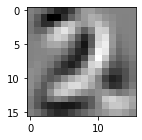

In [120]:
Aj = U1.dot(S[:,:,3]).dot(U2.T)
plot_image(Aj)

In [121]:
 Cj = np.tensordot(Z, Aj)/np.tensordot(Aj, Aj)
 Cj

0.03371456395196703

In [122]:
G = np.linalg.norm(Z-Cj*Aj, "fro")
G

7.732825117183781

In [123]:
result_Train_list, y_Train_predict, result_Train_predict, result_Train_residual, result_Train_mse = hosvdAlgorithm(x_Train, y_Train, S_list, U_list, 12)

In [124]:
result_Train_predict

0.9728432313811548

In [125]:
result_Train_residual[7290]

array([0.01901249, 0.00534442, 0.01703906, 0.01886486, 0.01179938,
       0.01904816, 0.01567712, 0.01651261, 0.01078927, 0.01479354])

In [126]:
result_Train_mse

[3.198052393361679,
 1.4978740913454944,
 1.2891235770127554,
 0.9462350843505692,
 0.7939925936085585,
 0.7944040597997531,
 0.7104649567960499,
 0.5841448360993005,
 0.5739953367164998,
 0.5336716499794267,
 0.5542449595391579,
 0.5044575504046084]

Text(0.5, 0, 'number of basis')

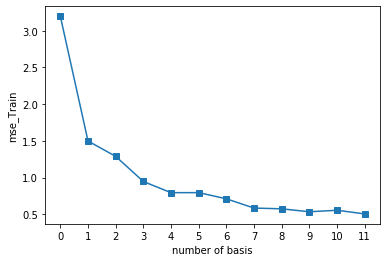

In [127]:
plt.plot(result_Train_mse,'s-')
plt.xticks(range(0,12))
plt.ylabel('mse_Train')
plt.xlabel('number of basis')

In [128]:
result_Test_list, y_Test_predict, result_Test_predict, result_Test_residual, result_Test_mse = hosvdAlgorithm(x_Test, y_Test, S_list, U_list, 12)

In [129]:
result_Test_predict

0.9451918285999004

In [130]:
result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']].shape

(110, 259)

In [131]:
result_Test_residual[2006]

array([0.01978696, 0.00195303, 0.01706042, 0.01849708, 0.01152748,
       0.0172219 , 0.01516978, 0.01641712, 0.01445125, 0.01415679])

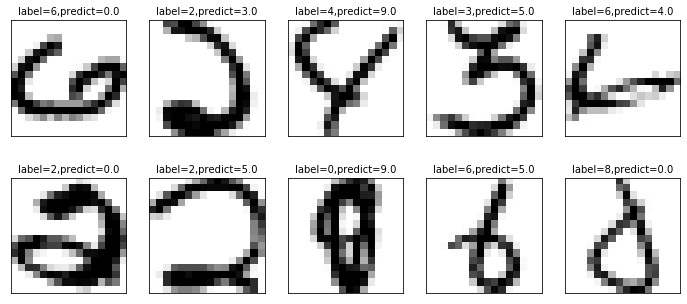

In [132]:
errorList = result_Test_list[result_Test_list['prediction'] != result_Test_list['actual']]

errorList.shape

plot_images_labels_prediction(errorList.iloc[:,np.arange(0, 256)], errorList.iloc[:,[256]], errorList.iloc[:,[257]],0,10)

In [133]:
totalCounts = result_Test_list[['actual']].groupby(['actual']).size().reset_index(name='totalCounts')
totalCounts = totalCounts.sort_values('actual', ascending=[True])
errorCounts = errorList[['actual']].groupby(['actual']).size().reset_index(name='errorCounts')
errorCounts = errorCounts.sort_values('actual', ascending=[True])
resultdf = pd.concat([totalCounts,pd.DataFrame(errorCounts, columns=['errorCounts'])], axis=1)
resultdf["successCounts"] = resultdf["totalCounts"]-resultdf["errorCounts"]
resultdf["probability"] = (resultdf["totalCounts"]-resultdf["errorCounts"])/resultdf["totalCounts"]
resultdf.sort_values('probability', ascending=[True])

actual  totalCounts  errorCounts  successCounts  probability
3       3          166           22            144     0.867470
2       2          198           18            180     0.909091
5       5          160           13            147     0.918750
4       4          200           14            186     0.930000
8       8          166           11            155     0.933735
7       7          147            7            140     0.952381
9       9          177            8            169     0.954802
6       6          170            6            164     0.964706
1       1          264            6            258     0.977273
0       0          359            5            354     0.986072

In [134]:
temp = errorList[['actual', 'prediction']].groupby(['actual', 'prediction']).size().reset_index(name='counts')

errorPrediction = np.zeros((4, 10))

for i in range(0,10):
    errorPrediction[0][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][1]
    errorPrediction[1][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[0][2]
    errorPrediction[2][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][1]
    errorPrediction[3][i] = temp[temp['actual'] == i].sort_values(['actual', 'counts'], ascending=[True, False]).iloc[1][2]

pd.DataFrame(errorPrediction, columns=np.arange(0, 10)) 

0    1    2     3    4    5    6    7    8    9
0  2.0  4.0  0.0   5.0  9.0  3.0  0.0  4.0  0.0  1.0
1  2.0  3.0  8.0  13.0  5.0  4.0  2.0  3.0  3.0  4.0
2  4.0  6.0  4.0   8.0  1.0  9.0  4.0  1.0  3.0  4.0
3  2.0  3.0  3.0   4.0  3.0  3.0  2.0  1.0  3.0  3.0

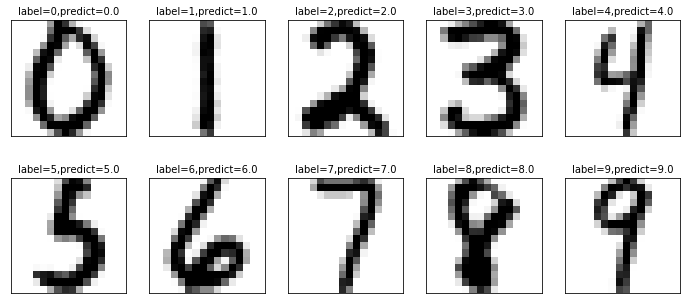

In [135]:
minList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['min']})


niceIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    niceIndex[i] = int(digitalList[digitalList['residual'] == minList['residual']['min'][i]].index.values[0])

niceList = result_Test_list.iloc[result_Test_list.index.get_indexer(niceIndex)]

plot_images_labels_prediction(niceList.iloc[:,np.arange(0, 256)], niceList.iloc[:,[256]], niceList.iloc[:,[257]],0,10)

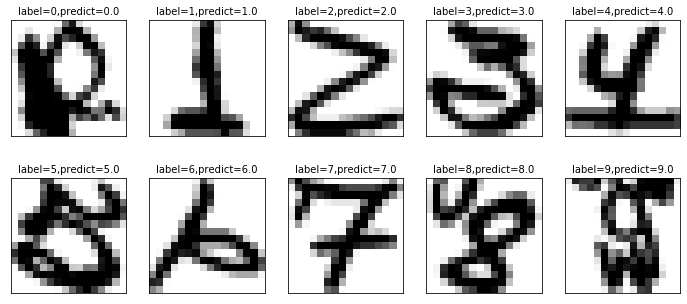

In [136]:
maxList = result_Test_list[result_Test_list['actual'] == result_Test_list['prediction']].groupby('actual').agg({'residual': ['max']})

uglyIndex = np.zeros(10)

for i in range(0,10):
    digitalList = result_Test_list[result_Test_list['actual'] == i]
    uglyIndex[i] = int(digitalList[digitalList['residual'] == maxList['residual']['max'][i]].index.values[0])

uglyList = result_Test_list.iloc[result_Test_list.index.get_indexer(uglyIndex)]

plot_images_labels_prediction(uglyList.iloc[:,np.arange(0, 256)], uglyList.iloc[:,[256]], uglyList.iloc[:,[257]],0,10)

In [137]:
result_Test_residual[2006]

array([0.01978696, 0.00195303, 0.01706042, 0.01849708, 0.01152748,
       0.0172219 , 0.01516978, 0.01641712, 0.01445125, 0.01415679])

In [138]:
result_Test_mse

[4.022421524663677,
 2.0269058295964126,
 1.8256103637269556,
 1.4867962132536123,
 1.2227204783258594,
 1.2825112107623318,
 1.1629297458893872,
 1.1031390134529149,
 1.0488290981564523,
 0.9725959142999502,
 0.9785749875435974,
 0.9237668161434978]

Text(0.5, 0, 'number of basis')

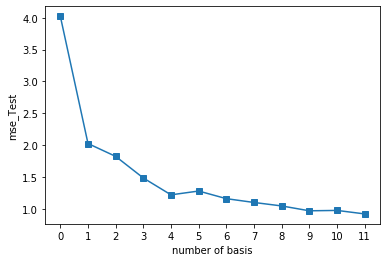

In [139]:
plt.plot(result_Test_mse,'s-')
plt.xticks(range(0,12))
plt.ylabel('mse_Test')
plt.xlabel('number of basis')

In [140]:
components = np.where(y_Test == 0)[0]
components
x_Test_0 = x_Test[components, :]
y_Test_0 = np.full(x_Test_0.shape[0],0)

In [141]:
result_Test_0_list, y_Test_0_predict, result_Test_0_predict, result_Test_0_residual, result_Test_0_mse = hosvdAlgorithm(x_Test_0, y_Test_0, S_list, U_list, 12)

In [142]:
result_Test_0_predict

0.9860724233983287

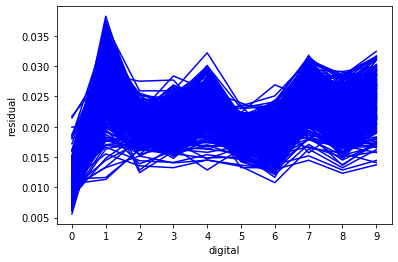

In [143]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_0.shape[0]):
    plt.plot(result_Test_0_residual[i],color = 'blue')

In [144]:
components = np.where(y_Test == 1)[0]
components
x_Test_1 = x_Test[components, :]
y_Test_1 = np.full(x_Test_1.shape[0],1)

In [145]:
result_Test_1_list, y_Test_1_predict, result_Test_1_predict, result_Test_1_residual, result_Test_1_mse = hosvdAlgorithm(x_Test_1, y_Test_1, S_list, U_list, 12)

In [146]:
result_Test_1_predict

0.9772727272727273

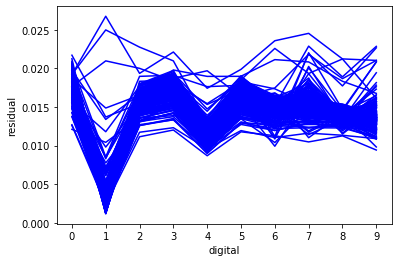

In [147]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_1.shape[0]):
    plt.plot(result_Test_1_residual[i],color = 'blue')

In [148]:
components = np.where(y_Test == 2)[0]
components
x_Test_2 = x_Test[components, :]
y_Test_2 = np.full(x_Test_2.shape[0],2)

In [149]:
result_Test_2_list, y_Test_2_predict, result_Test_2_predict, result_Test_2_residual, result_Test_2_mse = hosvdAlgorithm(x_Test_2, y_Test_2, S_list, U_list, 12)

In [150]:
result_Test_2_predict

0.9090909090909091

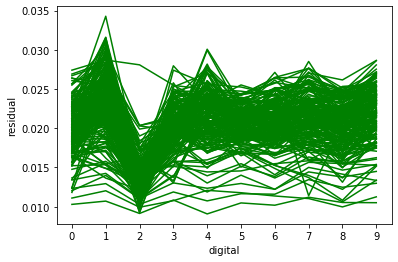

In [151]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_2.shape[0]):
    plt.plot(result_Test_2_residual[i],color = 'green')

In [152]:
components = np.where(y_Test == 3)[0]
components
x_Test_3 = x_Test[components, :]
y_Test_3 = np.full(x_Test_3.shape[0],3)

In [153]:
result_Test_3_list, y_Test_3_predict, result_Test_3_predict, result_Test_3_residual, result_Test_3_mse = hosvdAlgorithm(x_Test_3, y_Test_3, S_list, U_list, 12)

In [154]:
result_Test_3_predict

0.8674698795180723

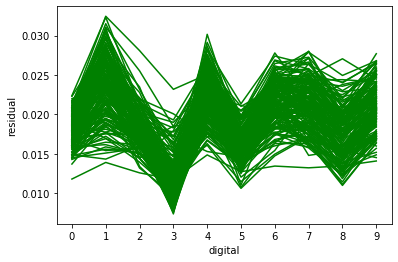

In [155]:
plt.xticks(range(0,10))
plt.ylabel('residual')
plt.xlabel('digital')
for i in range(x_Test_3.shape[0]):
    plt.plot(result_Test_3_residual[i],color = 'green')

In [156]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [157]:
result_Teacher_list, y_Teacher_predict, result_Teacher_predict, result_Teacher_residual, result_Teacher_mse = hosvdAlgorithm(x_Teacher, y_Teacher, S_list, U_list, 12)
result_Teacher_predict

0.9

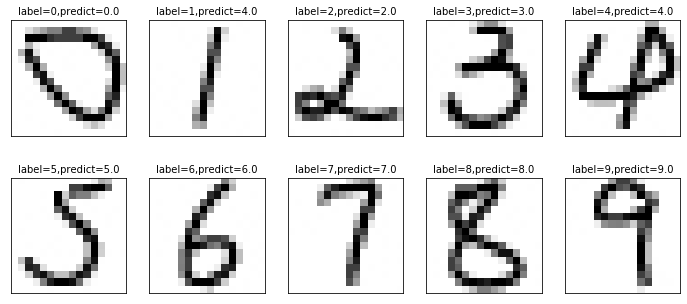

In [158]:
plot_images_labels_prediction(result_Teacher_list.iloc[:,np.arange(0, 256)], result_Teacher_list.iloc[:,[256]], result_Teacher_list.iloc[:,[257]],0,10)

In [159]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [160]:
result_Student_list, y_Student_predict, result_Student_predict, result_Student_residual, result_Student_mse = hosvdAlgorithm(x_Student, y_Student, S_list, U_list, 12)
result_Student_predict

0.9

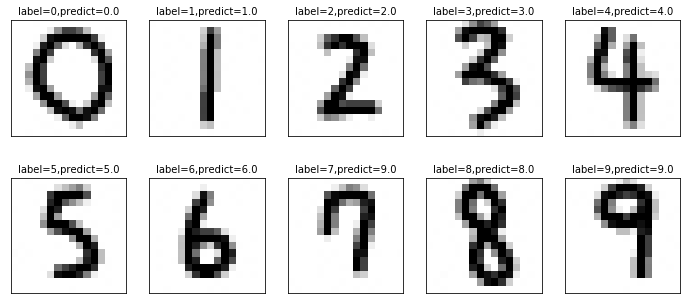

In [161]:
plot_images_labels_prediction(result_Student_list.iloc[:,np.arange(0, 256)], result_Student_list.iloc[:,[256]], result_Student_list.iloc[:,[257]],0,10)

# Classification Using Random Forest (隨機森林演算法)

In [162]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [163]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import r2_score

In [164]:
forest = RandomForestClassifier(criterion='entropy', n_estimators=10,random_state=3,n_jobs=2)

In [165]:
forest.fit(x_Train,y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=2,
                       oob_score=False, random_state=3, verbose=0,
                       warm_start=False)

In [166]:
y_Test_pred = forest.predict(x_Test)

In [167]:
prediction_data = pd.concat([pd.DataFrame(y_Test, columns=['actual']), pd.DataFrame(y_Test_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.916791230692576

In [168]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [169]:
y_Teacher_pred = forest.predict(x_Teacher)

In [170]:
prediction_data = pd.concat([pd.DataFrame(y_Teacher, columns=['actual']), pd.DataFrame(y_Teacher_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.8

In [171]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [172]:
y_Student_pred = forest.predict(x_Student)

In [173]:
prediction_data = pd.concat([pd.DataFrame(y_Student, columns=['actual']), pd.DataFrame(y_Student_pred, columns=['prediction'])], axis=1)
    
result = prediction_data[prediction_data['actual'] == prediction_data['prediction']].shape[0]/prediction_data.shape[0]
result

0.7

# Classification Using MLP (多層感知器)

In [174]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils

In [175]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [176]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [177]:
model = Sequential()
                
model.add(Dense(input_dim=256,
                units=256,
                kernel_initializer='normal',
                activation='relu'))

model.add(Dense(units=256,
                kernel_initializer='normal',
                activation='relu'))

model.add(Dense(units=10,
                kernel_initializer='normal',
                activation='softmax'))

In [178]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 0s - loss: 1.4382 - accuracy: 0.6235 - val_loss: 0.5638 - val_accuracy: 0.8670
Epoch 2/20
20/20 - 0s - loss: 0.3655 - accuracy: 0.9024 - val_loss: 0.2470 - val_accuracy: 0.9273
Epoch 3/20
20/20 - 0s - loss: 0.2189 - accuracy: 0.9395 - val_loss: 0.2074 - val_accuracy: 0.9445
Epoch 4/20
20/20 - 0s - loss: 0.1846 - accuracy: 0.9489 - val_loss: 0.1760 - val_accuracy: 0.9479
Epoch 5/20
20/20 - 0s - loss: 0.1494 - accuracy: 0.9606 - val_loss: 0.1670 - val_accuracy: 0.9520
Epoch 6/20
20/20 - 0s - loss: 0.1313 - accuracy: 0.9654 - val_loss: 0.1556 - val_accuracy: 0.9527
Epoch 7/20
20/20 - 0s - loss: 0.1137 - accuracy: 0.9710 - val_loss: 0.1557 - val_accuracy: 0.9520
Epoch 8/20
20/20 - 0s - loss: 0.0961 - accuracy: 0.9769 - val_loss: 0.1366 - val_accuracy: 0.9609
Epoch 9/20
20/20 - 0s - loss: 0.0837 - accuracy: 0.9793 - val_loss: 0.1326 - val_accuracy: 0.9630
Epoch 10/20
20/20 - 0s - loss: 0.0732 - accuracy: 0.9822 - val_loss: 0.1350 - val_accuracy: 0.9616
Epoch 11/20
20/20 -

In [179]:
scores = model.evaluate(x_Test , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 1ms/step - loss: 0.3249 - accuracy: 0.9327


0.9327354431152344

In [180]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [181]:
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [182]:
scores = model.evaluate(x_Teacher , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 9ms/step - loss: 11.1623 - accuracy: 0.9000


0.8999999761581421

In [183]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [184]:
y_StudentOneHot = np_utils.to_categorical(y_Student)

In [185]:
scores = model.evaluate(x_Student , y_StudentOneHot)
scores[1]

1/1 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000


1.0

# Classification Using CNN (卷積神經網路)

In [186]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.utils import np_utils

In [187]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [188]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [189]:
# 多加一個顏色的維度 
x_Train4D=x_Train_tensor.reshape(x_Train_tensor.shape[0],16,16,1).astype('float32')
x_Test4D=x_Test_tensor.reshape(x_Test_tensor.shape[0],16,16,1).astype('float32')

In [190]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [191]:
# define network structure

model = Sequential()

# initializing CNN

# 一個 Convolution Operation 搭配 一個 Pooling

# 二維卷積層 : filter為16, Kernel size為(5,5),Padding為(same)
model.add(Conv2D(filters=16,
                 kernel_size=(5,5),
                 padding='same',
                 input_shape=(16,16,1), 
                 activation='relu'))

# MaxPooling size為(2,2)
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolutional layer

model.add(Conv2D(filters=36,
                 kernel_size=(5,5),
                 padding='same',
                 activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

# Drop掉部分神經元避免overfitting
model.add(Dropout(0.25))

# 平坦化
model.add(Flatten())

# Fully Connected Networks

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(units=10,activation='softmax'))

In [192]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train4D, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 2s - loss: 1.7021 - accuracy: 0.4331 - val_loss: 0.7471 - val_accuracy: 0.7916
Epoch 2/20
20/20 - 2s - loss: 0.6700 - accuracy: 0.7786 - val_loss: 0.2881 - val_accuracy: 0.9157
Epoch 3/20
20/20 - 2s - loss: 0.3544 - accuracy: 0.8945 - val_loss: 0.2055 - val_accuracy: 0.9315
Epoch 4/20
20/20 - 2s - loss: 0.2547 - accuracy: 0.9246 - val_loss: 0.1625 - val_accuracy: 0.9452
Epoch 5/20
20/20 - 2s - loss: 0.2043 - accuracy: 0.9393 - val_loss: 0.1272 - val_accuracy: 0.9568
Epoch 6/20
20/20 - 2s - loss: 0.1775 - accuracy: 0.9496 - val_loss: 0.1244 - val_accuracy: 0.9589
Epoch 7/20
20/20 - 2s - loss: 0.1465 - accuracy: 0.9585 - val_loss: 0.0936 - val_accuracy: 0.9685
Epoch 8/20
20/20 - 2s - loss: 0.1311 - accuracy: 0.9606 - val_loss: 0.0861 - val_accuracy: 0.9740
Epoch 9/20
20/20 - 2s - loss: 0.1134 - accuracy: 0.9671 - val_loss: 0.0877 - val_accuracy: 0.9746
Epoch 10/20
20/20 - 2s - loss: 0.1060 - accuracy: 0.9691 - val_loss: 0.0788 - val_accuracy: 0.9746
Epoch 11/20
20/20 -

In [193]:
scores = model.evaluate(x_Test4D , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 5ms/step - loss: 0.1572 - accuracy: 0.9606


0.9606377482414246

In [194]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [195]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
x_Teacher4D=x_Teacher_tensor.reshape(x_Teacher_tensor.shape[0],16,16,1).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [196]:
scores = model.evaluate(x_Teacher4D , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 1.0000


1.0

In [197]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [198]:
x_Student_tensor = x_Student.reshape(len(x_Student), 16, 16).astype('float32')
x_Student4D=x_Student_tensor.reshape(x_Student_tensor.shape[0],16,16,1).astype('float32')
y_StudentOneHot = np_utils.to_categorical(y_Student)

In [199]:
scores = model.evaluate(x_Student4D , y_StudentOneHot)
scores[1]

1/1 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 1.0000


1.0

# Classification Using RNN (循環神經網路)

In [200]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,SimpleRNN
from keras.utils import np_utils

In [201]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [202]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [203]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [204]:
# define network structure

model = Sequential()

model.add(SimpleRNN(input_shape=(16,16),
                    units = 256,
                    unroll=True))

model.add(Dropout(0.1))

model.add(Dense(units=10,kernel_initializer='normal',activation='softmax'))

In [205]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train_tensor, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 1s - loss: 1.1618 - accuracy: 0.6746 - val_loss: 0.5629 - val_accuracy: 0.8670
Epoch 2/20
20/20 - 1s - loss: 0.4117 - accuracy: 0.8894 - val_loss: 0.2938 - val_accuracy: 0.9219
Epoch 3/20
20/20 - 1s - loss: 0.2610 - accuracy: 0.9292 - val_loss: 0.2136 - val_accuracy: 0.9438
Epoch 4/20
20/20 - 1s - loss: 0.2136 - accuracy: 0.9383 - val_loss: 0.1939 - val_accuracy: 0.9417
Epoch 5/20
20/20 - 1s - loss: 0.1648 - accuracy: 0.9549 - val_loss: 0.1657 - val_accuracy: 0.9548
Epoch 6/20
20/20 - 1s - loss: 0.1511 - accuracy: 0.9568 - val_loss: 0.1697 - val_accuracy: 0.9465
Epoch 7/20
20/20 - 1s - loss: 0.1427 - accuracy: 0.9594 - val_loss: 0.1313 - val_accuracy: 0.9609
Epoch 8/20
20/20 - 1s - loss: 0.1288 - accuracy: 0.9628 - val_loss: 0.1324 - val_accuracy: 0.9623
Epoch 9/20
20/20 - 1s - loss: 0.1179 - accuracy: 0.9642 - val_loss: 0.1616 - val_accuracy: 0.9541
Epoch 10/20
20/20 - 1s - loss: 0.1008 - accuracy: 0.9717 - val_loss: 0.1263 - val_accuracy: 0.9671
Epoch 11/20
20/20 -

In [206]:
scores = model.evaluate(x_Test_tensor , y_TestOneHot)
scores[1]

63/63 [==============================] - 0s 4ms/step - loss: 0.2665 - accuracy: 0.9337


0.9337319135665894

In [207]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [208]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [209]:
scores = model.evaluate(x_Teacher_tensor , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 3ms/step - loss: 4.1442 - accuracy: 0.1000


0.10000000149011612

In [210]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [211]:
x_Student_tensor = x_Student.reshape(len(x_Student), 16, 16).astype('float32')
y_StudentOneHot = np_utils.to_categorical(y_Student)

In [212]:
scores = model.evaluate(x_Student_tensor , y_StudentOneHot)
scores[1]

1/1 [==============================] - 0s 5ms/step - loss: 3.8478 - accuracy: 0.4000


0.4000000059604645

# Classification Using LSTM (長短期記憶循環神經網路)

In [213]:
from keras.models import Sequential
from keras.layers.recurrent import LSTM

In [214]:
x_Train, y_Train, x_Test, y_Test = getUspDataSet("./input/usps.h5")
print("training set (16x16) : %d 張" % x_Train.shape[0])
print("testing set (16x16) : %d 張" % x_Test.shape[0])

training set (16x16) : 7291 張
testing set (16x16) : 2007 張


In [215]:
x_Train_tensor = x_Train.reshape(len(x_Train), 16, 16).astype('float32')
x_Test_tensor = x_Test.reshape(len(x_Test), 16, 16).astype('float32')

In [216]:
# 把類別做Onehot encoding
y_TrainOneHot = np_utils.to_categorical(y_Train)
y_TestOneHot = np_utils.to_categorical(y_Test)

In [217]:
model = Sequential()

model.add(LSTM(input_shape=(16, 16),
                units=256,
                unroll=False))

model.add(Dropout(0.1))

model.add(Dense(units=10,kernel_initializer='normal',activation='softmax'))

In [218]:
# 訓練模型
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history=model.fit(x=x_Train_tensor, 
                        y=y_TrainOneHot,validation_split=0.2, 
                        epochs=20, batch_size=300,verbose=2)

Epoch 1/20
20/20 - 5s - loss: 1.8768 - accuracy: 0.3407 - val_loss: 1.4438 - val_accuracy: 0.4914
Epoch 2/20
20/20 - 5s - loss: 1.1428 - accuracy: 0.6284 - val_loss: 0.8761 - val_accuracy: 0.6923
Epoch 3/20
20/20 - 4s - loss: 0.7154 - accuracy: 0.7656 - val_loss: 0.5614 - val_accuracy: 0.8170
Epoch 4/20
20/20 - 4s - loss: 0.4407 - accuracy: 0.8579 - val_loss: 0.3999 - val_accuracy: 0.8657
Epoch 5/20
20/20 - 5s - loss: 0.3178 - accuracy: 0.9052 - val_loss: 0.3058 - val_accuracy: 0.8924
Epoch 6/20
20/20 - 4s - loss: 0.2442 - accuracy: 0.9228 - val_loss: 0.2728 - val_accuracy: 0.9102
Epoch 7/20
20/20 - 4s - loss: 0.2136 - accuracy: 0.9352 - val_loss: 0.2026 - val_accuracy: 0.9308
Epoch 8/20
20/20 - 4s - loss: 0.1772 - accuracy: 0.9470 - val_loss: 0.2098 - val_accuracy: 0.9390
Epoch 9/20
20/20 - 4s - loss: 0.1605 - accuracy: 0.9510 - val_loss: 0.1613 - val_accuracy: 0.9472
Epoch 10/20
20/20 - 4s - loss: 0.1275 - accuracy: 0.9623 - val_loss: 0.1434 - val_accuracy: 0.9568
Epoch 11/20
20/20 -

In [219]:
scores = model.evaluate(x_Test_tensor , y_TestOneHot)
scores[1]

63/63 [==============================] - 1s 24ms/step - loss: 0.2559 - accuracy: 0.9297


0.9297459125518799

In [220]:
y_Teacher = np.array([0,1,2,3,4,5,6,7,8,9])
x_Teacher = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_" + str(i) +".jpg", "r").convert("L")
    x_Teacher[i,:] = np.array(img).flatten()

In [221]:
x_Teacher_tensor = x_Teacher.reshape(len(x_Teacher), 16, 16).astype('float32')
y_TeacherOneHot = np_utils.to_categorical(y_Teacher)

In [222]:
scores = model.evaluate(x_Teacher_tensor , y_TeacherOneHot)
scores[1]

1/1 [==============================] - 0s 4ms/step - loss: 3.1102 - accuracy: 0.3000


0.30000001192092896

In [223]:
y_Student = np.array([0,1,2,3,4,5,6,7,8,9])
x_Student = np.zeros((10,256))

for i in range(10):
    img = Image.open("./digit/digit_s_" + str(i) +".jpg", "r").convert("L")
    x_Student[i,:] = np.array(img).flatten()

In [224]:
x_Student_tensor = x_Teacher.reshape(len(x_Student), 16, 16).astype('float32')
y_StudentOneHot = np_utils.to_categorical(y_Student)

In [225]:
scores = model.evaluate(x_Student_tensor , y_StudentOneHot)
scores[1]

1/1 [==============================] - 0s 2ms/step - loss: 3.1102 - accuracy: 0.3000


0.30000001192092896